In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator
from landlab.grid.mappers import map_max_of_link_nodes_to_link,  map_link_vector_components_to_node
from landlab.io import read_esri_ascii
import tidal_erosion_calculator as tec

In [2]:
# Set parameters (these are from the MarshMorpho2D source code)
tidal_period = 12.5 * 3600.0  # tidal period in seconds
tidal_range = 3.1  # tidal range in meters
roughness_w = 0.02  # Manning's n water
roughness_v = 0.1 #manning's n for veg
mean_sea_level = 0.0  # mean sea level in meters
mwd = 0.01  # minimum depth for water on areas higher than low tide water surface, meters
nodata_code = 999  # code for a DEM cell with no valid data
tcrgradeint = 0.2; # linear increase in tcr below MLW [pa/m
# Read the DEM to create a grid and topography field
(grid, z) = read_esri_ascii('zSW3.asc', name='topographic__elevation')

#need to create vegetation grid #change to veg at cells
veg = grid.add_zeros('vegetation',at='node');
veg[z<0] = 1;
veg_atlink = grid.map_max_of_link_nodes_to_link('vegetation')
grid.add_field('veg_atlink',veg_atlink,at='link')

# Configure boundaries: any nodata nodes, plus any nodes higher than mean high tide
grid.status_at_node[z==nodata_code] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[z>1.8] = grid.BC_NODE_IS_CLOSED
boundaries_above_msl = np.logical_and(grid.status_at_node==grid.BC_NODE_IS_FIXED_VALUE, z > 0.0)
grid.status_at_node[boundaries_above_msl] = grid.BC_NODE_IS_CLOSED

print('pre tfc:')
print(grid.at_node.keys())
print(grid.at_link.keys())

#variable rougness as field in grid
roughness_at_nodes = roughness_w + np.zeros(z.size)
roughness_at_nodes[z < 0.0] = roughness_v #or roughness_at_nodes[veg] = roughness_v
roughness = grid.add_zeros('roughness', at='link')
map_max_of_link_nodes_to_link(grid, roughness_at_nodes, out=roughness)

# Instantiate a TidalFlowCalculator component
tfc = TidalFlowCalculator(
        grid,
        tidal_period=tidal_period,
        tidal_range=tidal_range,
        roughness='roughness',
        mean_sea_level=mean_sea_level,
        min_water_depth=mwd,
)
tfc.run_one_step()

pre tfc:
['topographic__elevation', 'vegetation']
['veg_atlink']


In [3]:
tau_cr = 0.2 #Critical stress for unvegetated areas
tau_crv = 0.5  #Critical stress for vegetated areas
mud_erodability = (10**-5);  # mud erodability kg/m2/s
#should this be in seconds, days? he had it in days *24*3600

v = grid.at_link['veg_atlink']
tec.populateGrids(grid,tfc,tau_cr,tau_crv,v)

In [ ]:
U = grid.at_node['ebb_tide_flow__velocity_node']
print(U.mean())

In [ ]:
#tec.plot_tidal_flow(grid)
print((grid.has_field('cell','hydroperiod_cell')))
aa = grid.at_cell['hydroperiod_cell']
aa[1] = 1.5234
grid.add_field('hydroperiod_cell',aa,at='cell',clobber=True)

In [4]:
ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability, tidal_range, tcrgradeint)
#ok so for some reason erosion value is SUPER high -- no clue why...need to clear that up!
print(ero)
print(ero.mean())

[ 0.  0.  0. ...,  0.  0.  0.]
6.27452080986e-06


In [5]:
print(grid.at_node['erosion'].max())
print(grid.at_node['utide'].max())
print(grid.at_node['tauC'].max())
print(grid.at_node['roughness_node'].max())
print(grid.at_node['water_depth_at_node'].max())
t = grid.at_node['tauC']
tcr = grid.at_node['tau_cr_node']
tt = t/tcr
print(tt.max())
print(t.max())
print(tcr.max())

#so no idea why tauC is so high - in Giulio it's 4.3, for us it's 93
#also his max taucr is .5, ours is 199.99
#our high tauC drives a high erosion
#utide is similar range to his U (but note his does not have neg. values)
#I've removed his for-loop (which does decr. erosion a bit in his code) and
#I'm comparing his numbers sans for loop to our numbers (to make as close as possible)
#his max erosion is 7.9!!! hours is 160....

0.00478240048878
0.564726041144
239.619502779
0.1
2.496713
479.239005559
239.619502779
0.5


In [6]:
for i in range(5):
    ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability, tidal_range, tcrgradeint)
    print('ero mean: ' + str(ero.mean()))
    print('ero max: ' +str(ero.max()))
    print('z min: ' +str(z.min()))
    z = grid.at_node['topographic__elevation']
    z -= ero
    print('z min post erosion: ' +str(z.min()))
    tfc.run_one_step()
    tec.updategrids(grid,tfc)  
    
    #plt.figure()
    #imshow_grid(grid,grid.at_node['topographic__elevation'])
    #plt.title(str(i))
    

ero mean: 6.27452080986e-06
ero max: 0.00478240048878
z min: -2.609347
z min post erosion: -2.60938620643
ero mean: 6.26947416829e-06
ero max: 0.0047756302449
z min: -2.60938620643
z min post erosion: -2.60942539933
ero mean: 6.26444003808e-06
ero max: 0.0047688678204
z min: -2.60942539933
z min post erosion: -2.60946457877
ero mean: 6.25941913883e-06
ero max: 0.00476211335252
z min: -2.60946457877
z min post erosion: -2.60950374482
ero mean: 6.25441060711e-06
ero max: 0.00475536560373
z min: -2.60950374482
z min post erosion: -2.60954289755


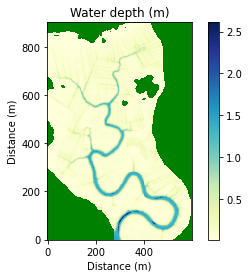

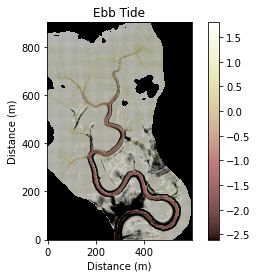

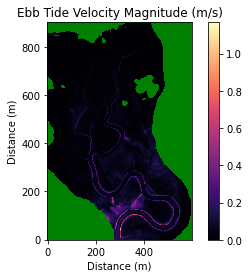

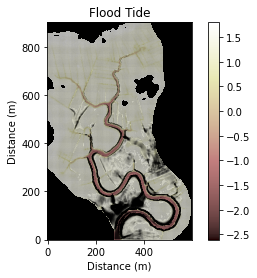

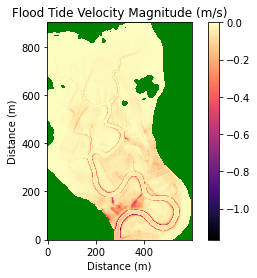

In [7]:
tec.plot_tidal_flow(grid)